# ML in Cybersecurity: Project II

## Team
  * **Team name**:  MMM
  * **Members**:  Maria Sargsyan (<email here>), Muneeb Aadil (2581794, maadil@mpi-inf.mpg.de), Muhammad Yaseen (2577833, myaseen@mpi-inf.mpg.de).


## Logistics
  * **Due date**: 28th November 2019, 13:59:59 (right before the lecture)
  * Email the completed notebook to: `mlcysec_ws1920_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 14-Nov-2019: Project 2 hand-out
  * **28-Nov-2019** (13:59:59): Email completed notebook
  * 5-Nov-2019: Project 2 discussion and summary
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal will be train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [16]:
import time 

import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path

from IPython.display import display, HTML
 
#%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
#%load_ext autoreload
#%autoreload 2

In [17]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars
  
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
import pandas as pd


In [18]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '2'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`

# Check that you are prepared with the data
#! printf '# train examples (Should be 13682) : '; ls data/train | wc -l
#! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data

In [19]:
from torch.utils.data import Dataset
import pandas as pd
import os
import torch


# We wrote our own PyTorch data loader


CLASSES = ["NothingFound", "Basun", "Agent", "Allaple", "AutoIt",
           "Patched", "Swizzor", "Texel", "VB", "Virut"]

class MalwareDataset(Dataset):
    def __init__(self, root_dir, dataset_type="train", transform=None):

        assert dataset_type in ["train","test","val"]
        db_path = os.path.join(root_dir, dataset_type + ".csv")
        self.malware_db = pd.read_csv(db_path)
        self.dataset_type = dataset_type if dataset_type != 'val' else 'train'
        self.root_dir = root_dir
        self.transform = transform
        # TODO: put CLASSES variable inside self.
        self.num_classes = len(CLASSES)

    def __len__(self):

        return len(self.malware_db)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the file name for this index
        mw_filename = self.malware_db.iloc[index,0] + "." + self.malware_db.iloc[index,1]

        # load and clean the data

        # set the corresponding location to 1
        label = [0]*len(CLASSES)
        readable_label = self.malware_db.iloc[index,1]
        label[self.get_class_index(readable_label)] = 1
        label_idx = self.get_class_index(readable_label)

        fq_path = os.path.join(self.root_dir, self.dataset_type, mw_filename)
        contents = open(os.path.join(self.root_dir, self.dataset_type, mw_filename)).readlines()
        contents_sanitized = [l.replace(' |',' ').strip(' \n')  for l in contents if not '#' in l]
        sample = {'trace': contents_sanitized, 'label': label, 'readable_label': readable_label,
                  'label_idx': label_idx, 
                  'fq_path': fq_path        # reqd for vectorizer
                  }

        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_class_index(self, label):

        """
        Just a simple way to vectorize the output labels using one-hot
        encoding at the load time
        """
        assert label in CLASSES
        return CLASSES.index(label)


## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [20]:
# PyTorch Transforms

from sklearn.preprocessing import OneHotEncoder
import numpy as np

import os
import pickle
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_trainset(root = '/raid/mlcysec19/student_directories/team9/vec/'):
    files = os.listdir(root)

    contents = [open(root + f) for f in files]
    vectorizer = CountVectorizer(input='file',
                            token_pattern='[0-9a-fA-F]+', # tokens aren't detected unless
                                                          # we use this regex
                            max_features=100,
                            ngram_range=(2,2))

    # By changing `max_features`, which determines dimensionality of representation
    # and `ngram_range`, which deteremines upto what level of ngrams we consider
    # we can create many different vectorizer schemes.

    # We tried following
    # 1. Unigram 25 dimension (max_features=25, ngram_range=(1,1))
    # 2. Unigram 50 dimension (max_features=50, ngram_range=(1,1))
    # 3. Unigram 100 dimension (max_features=100, ngram_range=(1,1))
    # 4. Unigram 200 dimension (max_features=200, ngram_range=(1,1))
    # 5. Unigram+Bigram 50 dimension (max_features=50, ngram_range=(1,2))
    # 6. Bigram 100 dimension (max_features=100, ngram_range=(2,2))

    X = vectorizer.fit_transform(contents)

    # Here we save the vectorizer file, which we then load in PyTorch transformers.
    vfh = open('bigrams_100.v','wb')
    pickle.dump(vectorizer, vfh)
    vfh.close()


"""
Some helpful data transformations for the MIST-format
"""

class CategoryOperationTransform(object):
    """
    This transform just returns the category and operation part of the trace as feature.
    It is useful for making the baseline model.
    """

    def __init__(self):
        self.num_feats = None

    def __call__(self, sample):

        # get all the cat/ops identifiers, they are in position 0 and 1
        # in each command

        cat_ops_list = []

        for cmd in sample['trace']:

            cmd_parts = cmd.split(' ')
            # convert from hex to int
            cat, op = int(cmd_parts[0], 16), int(cmd_parts[1], 16)

            cat_ops_list.append( (cat, op) )

        return { 'trace': cat_ops_list, 'label': sample['label'],'readable_label': sample['readable_label'] }


class CategoryCount(object):
    """
    This also only takes into account the category and operation part of the trace as a feature.
    Then, it uses one-hot encoding to represent how many rows got the same feature. Lastly, it sums
    along the 'line' dimension to get a vector.
    """
    def __init__(self, debug=False):
        self.num_categories = 20
        self.max_sys_call = 15
        self.num_feats = self.num_categories + self.max_sys_call # 20 category of system calls, and
        # 15 is the maximum number of system calls
        # self.encoder = OneHotEncoder('')
        self.debug = debug

    def __call__(self, sample):
        """
        Args:
            sample (dict): a sample dictionary containing 'trace', 'readable_label', and 'label' as keys.

        Returns:
            transformed_sample (dict)
        """

        trace = sample['trace']

        out = np.zeros(shape=(len(trace), self.num_feats))
        for i, cmd in enumerate(trace):
            cmd_parsed = cmd.split(' ')
            category = int(cmd_parsed[0], 16)
            sys_call = int(cmd_parsed[1], 16)

            try:
                out[i, category] = 1.
                out[i, 20 + sys_call] = 1.
            except:
                print("category: {}, 20+sys_call: {}, category hex".format(category, 20 + sys_call))

        # only replacing the old list of strings with transformed vector.
        sample['trace'] = np.sum(out, axis=0).astype(np.float32) # sum over the commands to get a vector.
        return sample


class FirstKArgs(object):
    """
    This transformer takes into account the first two columns (as previously), plus the first K
    argument colummns after the first two. The rationale is that, according to MIST documentation,
    earlier arguments are more important and significant than later ones (since later ones provide
    very thin details.)
    """

    def __init__(self, K=5):
        self.K = K
        self.num_categories = 20
        self.max_sys_call = 14
        self.num_feats = None # decide this.

    def __call__(self, sample):
        pass

    def prepare_tokens(self, data):
        pass


from sklearn.feature_extraction.text import CountVectorizer
import pickle

class HistogramTransform(object):

    """
    `vectorizer_file_path should be a scikit vectorizer
    """

    def __init__(self, vectorizer_file_path):
        
        self.vectorizer_file_path = vectorizer_file_path
        self.vectorizer = pickle.load(open(vectorizer_file_path,'rb'))


    def __call__(self, sample):
        
        sample['trace'] = self.vectorizer.transform([open(sample['fq_path'])])
        return sample

# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although I often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [25]:
# WARNING: THIS CLASSES LIST IS COPIED FROM MLW_LOADER.
CLASSES = ["NothingFound", "Basun", "Agent", "Allaple", "AutoIt", 
           "Patched", "Swizzor", "Texel", "VB", "Virut"]

def evaluate_preds(y_gt, y_pred):
    pass

def save_model(model, out_path):
    pass


def find_class_occurences(dir_path='./data/train'):
    """
    Returns a dictionary with having class name as key, and the number of instances
    having the class as its corresponding key.
    
    Args:
        dir_path (string): folder containing programs' stack trace.
    
    Returns:
        out (dict): (k,v) pairs where k = class name, v = number of occurences of that class.
    """
    out = dict()
    for program_file in tqdm(os.listdir(dir_path)):
        class_name = program_file.split('.')[-1]
        out[class_name] = out.get(class_name, 0) + 1
    return out
        
def get_class_weights(occ):
    """
    Given class occurences dictionary, it returns a numpy array containing the respective
    weight for each class.
    
    Args:
        occ (dict): (k,v) pairs where k = class name, v = number of occurences of that class.
        
    Returns:
        out (np.array) = an array of shape (num_classes,) containing the weight of each class.
    """
    # finding total number of examples in the set.
    total = 0.0
    for _, v in occ.items():
        total += v
    
    out = np.zeros((len(CLASSES), ))
    for k, v in occ.items():
        weight = 1. / (occ[k] / total)
        out[CLASSES.index(k)] = weight
    
    return out

In [27]:
class_occ = find_class_occurences(dir_path="./data/train")
class_weights = get_class_weights(class_occ)

100%|██████████| 42/42 [00:00<00:00, 29862.82it/s]


## 2.a.1 Define Dataset and Transformation to use.

In [37]:
# load dataset.
import malware_loader as mlw_loader
import malware_transforms as mlw_transforms

vectorizer = mlw_transforms.CategoryCount()


data_path = "./data"
#data_path = "./data-debug"

train_dataset = mlw_loader.MalwareDataset(root_dir=data_path, dataset_type='train', transform=vectorizer)
test_dataset = mlw_loader.MalwareDataset(root_dir=data_path, dataset_type='test', transform=vectorizer)
val_dataset = mlw_loader.MalwareDataset(root_dir=data_path, dataset_type='val', transform=vectorizer)

In [38]:
# setting some dataset dependent features.
num_classes = train_dataset.num_classes
num_feats = vectorizer.num_feats

## 2.b. Define Model

Describe your model here.

In [39]:
# please see models.py file for models definition

import anns 

## 2.c. Set Hyperparameters

In [40]:
# Define your hyperparameters here

# model instantiation

expt_name = 'baseline.model'

hidden_layers = [128, 256, 128, 64, 32, 16]

# Optimization
n_epochs = 1
batch_size = 32
lr = 1e-3
momentum = 0.9
num_workers = 4


## 2.d. Train your Model

In [41]:
# Feel free to edit anything in this block
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = anns.ANN(input_dim=num_feats, hidden_layers=hidden_layers,
                 output_dim=num_classes).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# loss function
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights))

In [42]:
def train_epoch(loader, model, criterion, optimizer, device, print_every=10):
    """Trains the model for one epoch"""
    model.train()
    loader_iterable = tqdm(loader)

    running_loss = 0.0

    for i, sample in enumerate(loader_iterable):
        X_batch, Y_batch = sample['trace'], sample['label_idx']
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_pred = model(X_batch)

        loss = criterion(Y_pred, Y_batch)
        running_loss = running_loss + loss.data
        
        if (i % print_every) == 0:
            pass
        #print("Loss at iteration {}: {}".format(i, loss.data))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = running_loss / len(loader_iterable)
    return mean_loss

In [43]:
def validate_epoch(loader, model, criterion, device, print_every=10):
    """Validates the trained model"""
    model.eval()
    loader_iterable = tqdm(loader)
    running_loss = 0.0

    for i, sample in enumerate(loader_iterable):
        X_batch, Y_batch = sample['trace'], sample['label_idx']
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_pred = model(X_batch)

        loss = criterion(Y_pred, Y_batch)
        running_loss += loss.data

        if (i % print_every) == 0:
            pass
        #print("Loss at iteration {}: {}".format(i, loss.data))

    mean_loss = running_loss / len(loader_iterable)
    return mean_loss

In [24]:
train_losses, test_losses = [], []
for epoch in range(n_epochs):
    print("Epoch [{} / {}]".format(epoch+1, n_epochs))

    print("Training...")
    mean_loss_train = train_epoch(train_loader, model, criterion, optimizer, device)
    print("Training Loss: {}".format(mean_loss_train))
    train_losses.append(mean_loss_train)

    print("Validating...")
    mean_loss_test = validate_epoch(val_loader, model, criterion, device)
    print("Testing Loss: {}".format(mean_loss_test))
    test_losses.append(mean_loss_test)

## 2.e. Evaluate model

In [6]:
def predict(loader, model, device):
    model.eval()
    y_preds, y_gts = [], []

    for sample in tqdm(loader):
        X_batch, Y_batch = sample['trace'], sample['label_idx']
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        Y_scores = model(X_batch)
        
        _, Y_pred = Y_scores.max(1)
        
        y_preds.append(Y_pred)
        y_gts.append(Y_batch)
        
    return torch.cat(y_preds), torch.cat(y_gts)

In [53]:
# get predictions
pred_class, actual_class = predict(test_loader, model)

# Evaluation Metric: F1 score.
f1score = f1_score(actual_class, pred_class.numpy(), average=None)

mean_f1score = f1score.mean()
print("mean f1 Score: {}".format(mean_f1score))

0.3435772851503188

## 2.f. Save Model + Data

In [ ]:
# Feel free to edit anything in this block

save_path = '{0}-checkpoint'.format(expt_name)
torch.save(model.state_dict(), save_path)

with open("history.pkl","wb") as fn:
    pickle.dump({'train_losses': train_losses,
                'test_losses': test_losses,
                'mean_f1score': mean_f1score}, fn)


## 2.g. Load Model and Plot Statistics

We only load our best performing model and plot its statistics.

### 2.g.1. Plot Learning Curves.

<IPython.core.display.Javascript object>


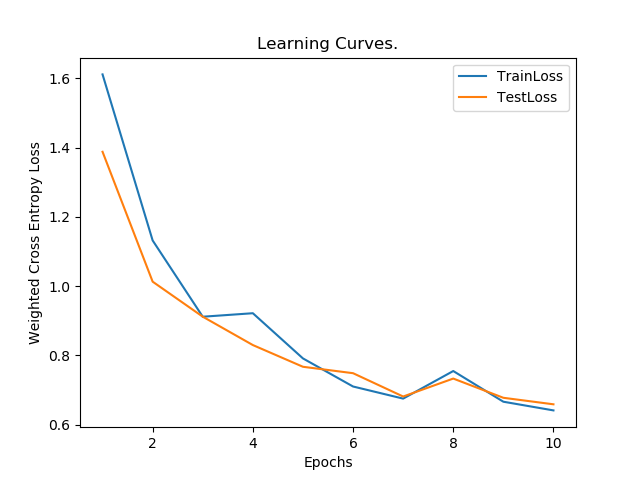

Text(0.5, 1.0, 'Learning Curves.')

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
import pickle
import numpy as np

best_model = 'vectorizer50'
history_filename = 'history-{}.model.pkl'.format(best_model)
ckpt_filename = '{}.model-checkpoint'.format(best_model)

with open(history_filename, 'rb') as fn:
    history_dict = pickle.load(fn)

train_losses = history_dict['train_losses']
test_losses = history_dict['test_losses']

def _process(l):
    out = []
    for _l in l:
        out.append(_l.data)
    return np.array(out)

train_losses = _process(train_losses)
test_losses = _process(test_losses)

fig, ax = plt.subplots()
ax.plot(range(1, train_losses.shape[0] + 1), train_losses, label='TrainLoss')
ax.plot(range(1, train_losses.shape[0] + 1), test_losses, label='TestLoss')
ax.legend()

ax.set_xlabel('Epochs')
ax.set_ylabel("Weighted Cross Entropy Loss")
ax.set_title("Learning Curves.")

### 2.g.2. Compare the trained models

<IPython.core.display.Javascript object>


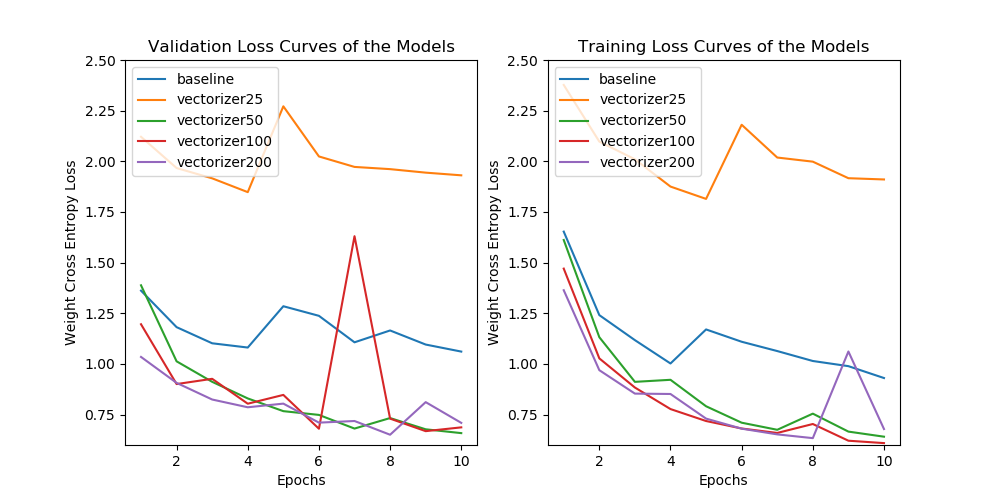

(0.6, 2.5)

In [35]:
models = ['baseline', 'vectorizer25', 'vectorizer50', 'vectorizer100', 'vectorizer200']
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
for model in models:
    history_filename = 'history-{}.model.pkl'.format(model)

    with open(history_filename, 'rb') as fn:
        history_dict = pickle.load(fn)

    train_losses = history_dict['train_losses']
    test_losses = history_dict['test_losses']

    train_losses = _process(train_losses)
    test_losses = _process(test_losses)
    
    ax[1].plot(range(1, train_losses.shape[0] + 1), train_losses, label=model)
    ax[0].plot(range(1, train_losses.shape[0] + 1), test_losses, label=model)

ax[0].legend(loc='upper left')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Weight Cross Entropy Loss')
ax[0].set_title('Validation Loss Curves of the Models')

ax[1].legend(loc='upper left')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Weight Cross Entropy Loss')
ax[1].set_title('Training Loss Curves of the Models')

# same y-axis of both subplots
ax[0].set_ylim([0.6, 2.5])
ax[1].set_ylim([0.6, 2.5])

### 2.g.2. Plot Confusion Matrix

In [7]:
import malware_loader as mlw_loader
import malware_transforms as mlw_transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch
import anns

# Load test dataset to do predictions on.
vectorizer = mlw_transforms.HistogramTransform("./vectorizer_100ft.v", dim=100)
test_dataset = mlw_loader.MalwareDataset(root_dir='./data/', dataset_type='test', transform=vectorizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


# load model and its weights
hidden_layers = [128, 256, 128, 64, 32, 16]
model = anns.ANN(100, hidden_layers=hidden_layers, output_dim=10)
weights_file = './vectorizer100.model-checkpoint'
model.load_state_dict(torch.load(weights_file))
device = torch.device('cpu')

pred_class, actual_class = predict(test_loader, model, device)

100%|██████████| 313/313 [04:52<00:00,  1.07it/s]


Normalized confusion matrix


<IPython.core.display.Javascript object>


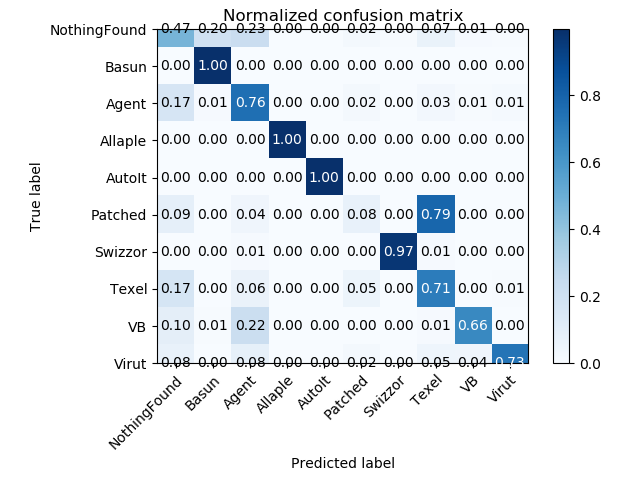

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

CLASSES = ["NothingFound", "Basun", "Agent", "Allaple", "AutoIt", 
           "Patched", "Swizzor", "Texel", "VB", "Virut"]

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(actual_class, pred_class, CLASSES, normalize=True)

---

# 3. Analysis

## 3.a. Summary: Main Results

If you tried other approaches, summarize their results here.

|        | Input Representation | Model |  Final Training Loss | Final Validation Loss | Test F1-Score |
|--------|----------------------|-------|---------|-------------|-------------|
| Baseline | CategoryCount       | MLP   | 0.93           | 1.06      | 0.59           |
| Model2  | HistogramVectorizer25 | MLP | 1.91 | 1.93 | 0.18 |
| Model3  | HistogramVectorizer50 | MLP | 0.64 | 0.65 | 0.707 |
| Model4  | HistogramVectorizer100 | MLP | 0.60 | 0.68 | 0.702 |
| Model5  | HistogramVectorizer200 | MLP | 0.67 | 0.709 | 0.666 |

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?

### 3.b.1. Performance of Simplest Approach (Baseline)

Our simplest approach was to simply one-hot encode the command category and system call and take the sum of these one-hot-encoded vectors to get a vector per document. For more details, please see the `malware_transforms/CategoryCount` class.

The evaluation metric we used was F1 score; accuracy was dismissed because the classes in the problem are highly imbalanced.

We got ~ 59% mean F1-score (mean F1 score = average of F1 score for each class) for the baseline model. 

### 3.b.2. Most Helpful Vectorized Representations
Our most effective representation, according to mean F1 score, is Histogram Transform with `n_dim = 100`. 

### 3.b.3. Difficult Malwares to Detect
In the plotted confusion matrix above, we notice that the following classes are difficult to detect:
1. **Patched:** The class `Patched` has the worst F1-score, according to the confusion matrix. It is mostly confused (around ~80% of the time) with `Texel` class.
2. **Nothing Found:** The class `Nothing Found` is also confused with `Basun` and `Agent` classes. This is arguably because the classes `Basun` and `Agent` are the majority classes in the training set, due to which the bias is somewhat shifted towards the majority class. Although weighted cross entropy loss alleviates this issue to a significant extent, it still sometimes causes a confusion. 

### 3.b.4. Comments on Loss Function and Evaluation Metric
1. Because the classes are highly unbalanced, we used *weight* cross entropy loss, where the loss of each example was scaled by the weight of the class of that example. The weight of each class is computed as the inverse of empirical probabilities in the dataset. For more details, please refer to `get_class_weights` function.

2. Similarly, we used F1-score instead of accuracy for the evaluation metric because F1 score is able to handle imbalanced classes.


### 3.b.5. Comments on Dimensions of Histogram Transformer

In [ ]:
# According to MIST Format documentation only the first few arguments are importants
# as we go more to the right, arguments become much less informative.
# After doing a static analysis of token frequencies we tried following 6 different
# representations:
# 1. Unigram with 25 dimensions
# 2. Unigram with 50 dimensions
# 3. Unigram with 100 dimensions
# 4. Unigram with 200 dimensions
# 5. Unigram+Bigram v 50 dimensions
# 6. Bigram with 100 dimensions
